### Import Dependencies

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [6]:
reviews_full_dataset = pd.read_csv('data/reviews.csv')
reviews_full_dataset.head(2)

,album_title,artists,genres,authors,best_new,publish_datetime,review_link,article,score
0,hypochondriac,brakence,ROCK,H.D. ANGEL,0,2022-12-15T05:01:00,https://pitchfork.com/reviews/albums/brakence-...,brakence’s songs surge with combative angst an...,7.3
1,Call and Response,Stefan Goldmann,ELECTRONIC,PHILIP SHERBURNE,0,2022-12-15T05:00:00,https://pitchfork.com/reviews/albums/stefan-go...,"In 1947, Bill Putnam discovered the future of ...",6.8


### Train-Test Split
We will conduct all analyses only on a train set, as to avoid any "look-ahead" bias


In [7]:
reviews, _ = train_test_split(reviews_full_dataset, test_size=0.2, random_state=0, shuffle=True)

### Pre-processing

In [8]:
# Parse genres: take only the first genre when album has multiple 
reviews = reviews.copy()
reviews['genres'].fillna('other', inplace=True)
reviews['genres'] = reviews['genres'].apply(lambda x: x.split(' / ')[0].lower())
reviews.rename(columns={'genres': 'genre'}, inplace=True)

### Initial Exploratory Data Analysis

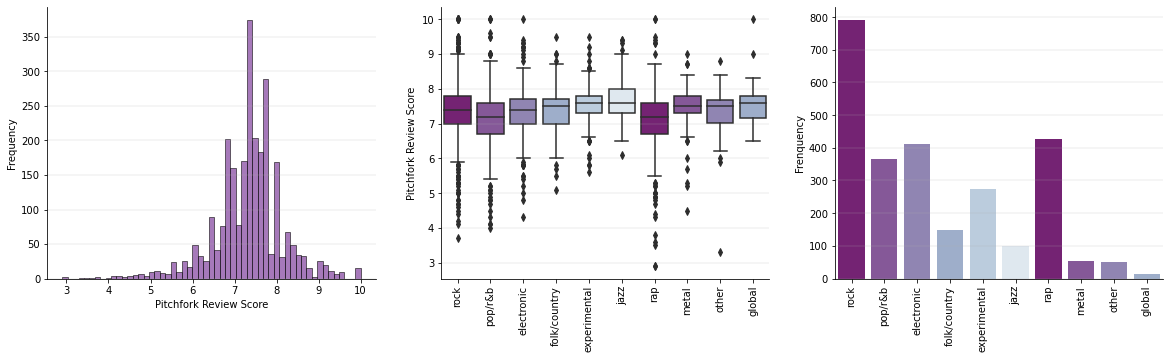

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
palette = sns.color_palette('BuPu_r')
sns.histplot(data=reviews['score'], ax=axs[0], color=palette[1])
sns.boxplot(data=reviews, x='genre', y='score', ax=axs[1], palette=palette)
sns.countplot(x=reviews['genre'], palette=palette)

axs[0].set_xlabel('Pitchfork Review Score')
axs[0].set_ylabel('Frequency')

axs[1].set_xlabel('')
axs[1].set_ylabel('Pitchfork Review Score')
axs[1].tick_params(axis='x', rotation=90)

axs[2].set_xlabel('')
axs[2].set_ylabel('Frenquency')
axs[2].tick_params(axis='x', rotation=90)

for ax in axs:
    ax.yaxis.grid(which='major', linewidth=.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.patch.set_alpha(0.0)
    
plt.show()

### Sentiment Analysis

#### 1. NLTK - VADER (Valence Aware Dictionary and sEntiment Reasoner)

This package relies on a rules-based sentiment analyzer, attaching a positive or negative rating to specific words and will consider negation. 

The shortcoming of this package is that as text gets longer (i.e. a full album review), more neutral words are present and the overall score becomes neutralized. Additionally, because it is rules-based (rather than a pre-trained model), sarcasm, jargon or figures of speech are misinterpreted. 

The package returns a negative *(neg)*, neutral *(neu)*, positive *(pos)*, and compound *(comp)* score. 

- **neg** + **neu** + **pos** = 1
- **comp**: value between -1 and +1

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [12]:
sia_vader = SentimentIntensityAnalyzer()
def get_vader_sentiment(text, sia=sia_vader):
    neg, neu, pos, comp = sia.polarity_scores(text).values()
    return pd.Series([neg, neu, pos, comp])
reviews[['neg', 'neu', 'pos', 'comp']] = reviews['article'].apply(get_vader_sentiment)

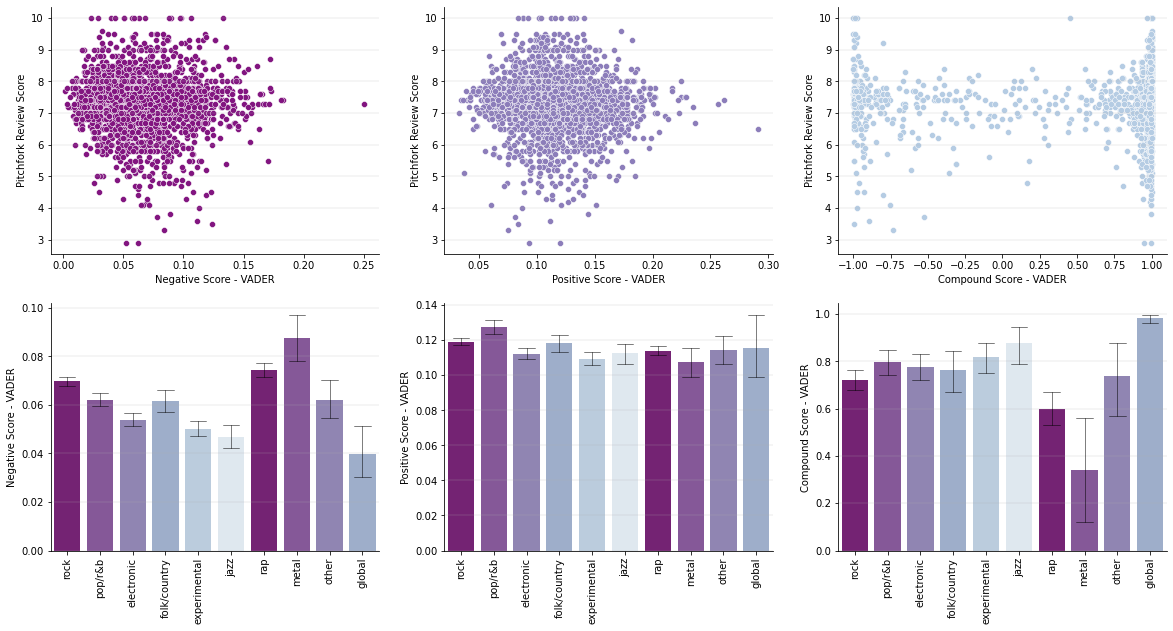

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
palette = sns.color_palette('BuPu_r')
sns.scatterplot(data=reviews, x='neg', y='score', ax=axs[0,0],  color=palette[0])
sns.scatterplot(data=reviews, x='pos', y='score', ax=axs[0,1],  color=palette[2])
sns.scatterplot(data=reviews, x='comp', y='score', ax=axs[0,2],  color=palette[4])
sns.barplot(data=reviews, x='genre', y='neg', ax=axs[1,0],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)
sns.barplot(data=reviews, x='genre', y='pos', ax=axs[1,1],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)
sns.barplot(data=reviews, x='genre', y='comp', ax=axs[1,2],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)

axs[0,0].set_xlabel('Negative Score - VADER')
axs[0,1].set_xlabel('Positive Score - VADER')
axs[0,2].set_xlabel('Compound Score - VADER')

axs[0,0].set_ylabel('Pitchfork Review Score')
axs[0,1].set_ylabel('Pitchfork Review Score')
axs[0,2].set_ylabel('Pitchfork Review Score')

axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('')
axs[1,2].set_xlabel('')

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis='x', rotation=90)
axs[1,2].tick_params(axis='x', rotation=90)

axs[1,0].set_ylabel('Negative Score - VADER')
axs[1,1].set_ylabel('Positive Score - VADER')
axs[1,2].set_ylabel('Compound Score - VADER')

for ax in axs:
    for a in ax:
        a.yaxis.grid(which='major', linewidth=.25)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.patch.set_alpha(0.0)

plt.show()

#### 2. TextBlob - Polarity & Subjectivity

This package also relies on a rules-based sentiment analyzer and has the same shortcomings as the package from NLTK. However, this package also offers a score related to the subjectivity of a text.

The package returns a *polarity* and *subjectivity* score. 

- **polarity**: value between -1 and +1
- **subjectivity**: value between 0 and 1

In [14]:
from textblob import TextBlob

In [15]:
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    polarity, subjectivity = blob.sentiment
    return pd.Series([polarity, subjectivity])
reviews[['polarity', 'subjectivity']] = reviews['article'].apply(get_textblob_sentiment)

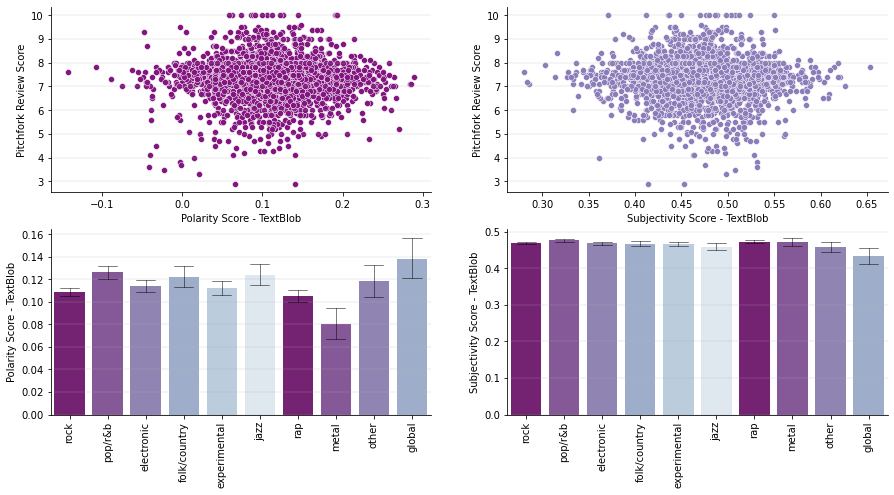

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,7.5))
palette = sns.color_palette('BuPu_r')
sns.scatterplot(data=reviews, x='polarity', y='score', ax=axs[0,0],  color=palette[0])
sns.scatterplot(data=reviews, x='subjectivity', y='score', ax=axs[0,1],  color=palette[2])
sns.barplot(data=reviews, x='genre', y='polarity', ax=axs[1,0],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)
sns.barplot(data=reviews, x='genre', y='subjectivity', ax=axs[1,1],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)

axs[0,0].set_xlabel('Polarity Score - TextBlob')
axs[0,1].set_xlabel('Subjectivity Score - TextBlob')

axs[0,0].set_ylabel('Pitchfork Review Score')
axs[0,1].set_ylabel('Pitchfork Review Score')

axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('')

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis='x', rotation=90)

axs[1,0].set_ylabel('Polarity Score - TextBlob')
axs[1,1].set_ylabel('Subjectivity Score - TextBlob')

for ax in axs:
    for a in ax:
        a.yaxis.grid(which='major', linewidth=.25)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.patch.set_alpha(0.0)

plt.show()

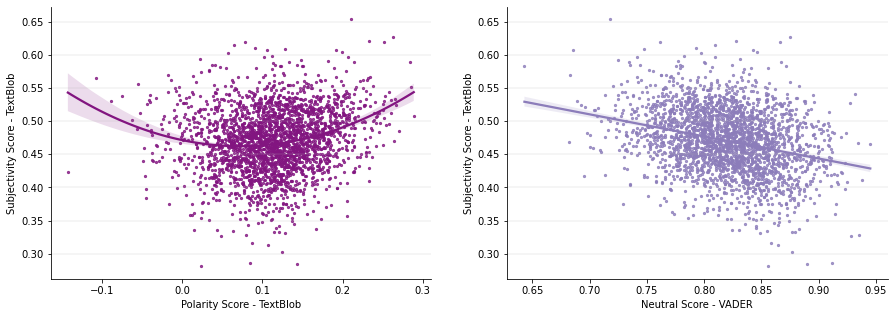

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
palette = sns.color_palette('BuPu_r')
sns.regplot(data=reviews, x='polarity', y='subjectivity', ax=axs[0], color=palette[0], order=2, scatter_kws={'s':5})
sns.regplot(data=reviews, x='neu', y='subjectivity', ax=axs[1], color=palette[2], scatter_kws={'s':5})

axs[0].set_xlabel('Polarity Score - TextBlob')
axs[0].set_ylabel('Subjectivity Score - TextBlob')

axs[1].set_xlabel('Neutral Score - VADER')
axs[1].set_ylabel('Subjectivity Score - TextBlob')

for ax in axs:
    ax.yaxis.grid(which='major', linewidth=.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.patch.set_alpha(0.0)
    
plt.show()

#### 3. Flair - Pre-trained Embedding-based Model

Flair is a pre-trained embedding-based model--each word is represented within a vector space. This can take into account textual context, unlike rules-based approaches. The shortcoming of this model is that it is much slower to implement. 

The package returns a label, *POSITIVE* or *NEGATIVE*, along with a confidence score between 0 and 1. We will convert this confidence score into a composite score (between -1 and +1), and a positive and negative score (each between 0 and 1).

In [2]:
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
sia_flair = TextClassifier.load('en-sentiment')
def get_flair_sentiment(text, sia=sia_flair):
    sentence = Sentence(text)
    sia_flair.predict(sentence)   
    value = sentence.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        score = sentence.labels[0].to_dict()['confidence']
    else:
        score = -(sentence.labels[0].to_dict()['confidence'])
    return score

reviews['flair'] = reviews['article'].apply(get_flair_sentiment)

2022-12-17 17:14:45,006 loading file /Users/benepstein/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
reviews['flair_pos'] = reviews['flair'].apply(lambda x: x if x > 0 else 1 + x)
reviews['flair_neg'] = reviews['flair'].apply(lambda x: -x if x < 0 else 1 - x)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
palette = sns.color_palette('BuPu_r')
sns.scatterplot(data=reviews, x='flair', y='score', ax=axs[0,0],  color=palette[0])
sns.scatterplot(data=reviews, x='flair_pos', y='score', ax=axs[0,1],  color=palette[2])
sns.scatterplot(data=reviews, x='flair_neg', y='score', ax=axs[0,2],  color=palette[4])
sns.barplot(data=reviews, x='genre', y='flair', ax=axs[1,0],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)
sns.barplot(data=reviews, x='genre', y='flair_pos', ax=axs[1,1],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)
sns.barplot(data=reviews, x='genre', y='flair_neg', ax=axs[1,2],  palette=palette, ci=95, errcolor='k', errwidth=0.5, capsize=0.5)

axs[0,0].set_xlabel('Compound Score - Flair')
axs[0,1].set_xlabel('Positive Score - Flair')
axs[0,2].set_xlabel('Negative Score - Flair')

axs[0,0].set_ylabel('Pitchfork Review Score')
axs[0,1].set_ylabel('Pitchfork Review Score')
axs[0,2].set_ylabel('Pitchfork Review Score')

axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('')
axs[1,2].set_xlabel('')

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis='x', rotation=90)
axs[1,2].tick_params(axis='x', rotation=90)

axs[1,0].set_ylabel('Compound Score - Flair')
axs[1,1].set_ylabel('Positive Score - Flair')
axs[1,2].set_ylabel('Negative Score - Flair')

for ax in axs:
    for a in ax:
        a.yaxis.grid(which='major', linewidth=.25)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.patch.set_alpha(0.0)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7.5,5))
palette = sns.color_palette('BuPu_r')
sns.regplot(data=reviews, x='flair', y='subjectivity', ax=ax, color=palette[0], order=2, scatter_kws={'s':5})

ax.set_xlabel('Compound Score - Flair')
ax.set_ylabel('Subjectivity Score - TextBlob')

ax.yaxis.grid(which='major', linewidth=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.patch.set_alpha(0.0)
    
plt.show()

### Calculate and Save Down All Sentiment Scores for Complete Dataset

In [ ]:
reviews_full_dataset[['neg', 'neu', 'pos', 'comp']] = reviews_full_dataset['article'].apply(get_vader_sentiment)
reviews_full_dataset[['polarity', 'subjectivity']] = reviews_full_dataset['article'].apply(get_textblob_sentiment)
reviews_full_dataset['flair'] = reviews_full_dataset['article'].apply(get_flair_sentiment)
reviews_full_dataset['flair_pos'] = reviews_full_dataset['flair'].apply(lambda x: x if x > 0 else 1 + x)
reviews_full_dataset['flair_neg'] = reviews_full_dataset['flair'].apply(lambda x: -x if x < 0 else 1 - x)
reviews_full_dataset.to_csv('data/reviews_sentiment.csv', index=False)